# Insper Jr. 

# Análise de Dados para R. Amaral Office
___


In [2]:
import pandas as pd
import os
import math
from statsmodels.tsa.seasonal import STL

%matplotlib inline
import matplotlib.pyplot as plt


## LEITURA DA BASE DE DADOS

In [3]:
filename = 'Base de Dados R. Amaral Office.xlsx'

if filename in os.listdir():
    print(f'Parece que o arquivo {filename} está na mesma pasta do notebook da avaliação, yay!\n')
    
else:
    print(f'Não encontrei o arquivo {filename}.\n'
          f'O notebook e os arquivos de dados desta avaliação devem ser salvos dentro da mesma pasta no seu computador.\n')

Parece que o arquivo Base de Dados R. Amaral Office.xlsx está na mesma pasta do notebook da avaliação, yay!



In [4]:
# Carregando os dados
df = pd.read_excel(filename)
df.head()


,id_pedido,nome_cliente,modo_envio,estado,vendas,quantidade,desconto,lucro,segmento,região,...,dia_pedido,dia_semana_pedido,mes_pedido,ano_pedido,dia_envio,mes_envio,ano_envio,data_pedido,mes_ano,tempo_preparacao
0,1,Muhammed MacIntyre,Expresso,Paraná,825.174,9,0.30,-117.8820,Corporativo,Sul,...,4,Domingo,9,2016,6,9,2016,42617,42617,2
1,2,Ruben Dartt,Normal,São Paulo,411.332,4,0.15,-4.8392,Consumidor,Sudeste,...,5,Sexta-feira,9,2014,9,9,2014,41887,41887,4
2,3,Liz Pelletier,Mesmo Dia,São Paulo,411.332,4,0.15,-4.8392,Home Office,Sudeste,...,28,Quinta-feira,11,2013,28,11,2013,41606,41606,0
3,4,Liz Pelletier,Expresso,Amapá,241.960,2,0.00,33.8744,Consumidor,Norte,...,30,Segunda-feira,5,2016,31,5,2016,42520,42520,1
4,5,Liz Pelletier,Normal,Sergipe,341.960,2,0.00,78.6508,Home Office,Nordeste,...,31,Terça-feira,12,2013,7,1,2014,41639,41639,7


## PREPARO DA BASE DE DADOS

In [5]:
type(df)
df.dtypes

id_pedido              int64
nome_cliente          object
modo_envio            object
estado                object
vendas               float64
quantidade             int64
desconto             float64
lucro                float64
segmento              object
região                object
subcategoria          object
categoria             object
dia_pedido             int64
dia_semana_pedido     object
mes_pedido             int64
ano_pedido             int64
dia_envio              int64
mes_envio              int64
ano_envio              int64
data_pedido            int64
mes_ano                int64
tempo_preparacao       int64
dtype: object

## 5. Correlação de Eficiencia Operacinal e Logística com Promoções

In [17]:
import pandas as pd


df['data_pedido'] = pd.to_datetime(dict(
    year = df['ano_pedido'],
    month= df['mes_pedido'],
    day  = df['dia_pedido']
))


df['com_promocao'] = df['desconto'] > 0

#  Agregar vendas por dia 
daily = (
    df
    .groupby('data_pedido')
    .agg(
        total_vendas   = ('vendas', 'sum'),
        pedidos_com_promocao = ('com_promocao', 'sum'),  # quantos pedidos promocionais
        total_pedidos  = ('id_pedido', 'size')
    )
    .reset_index()
)

# dia teve (ao menos) uma promoção? 
daily['dia_promocional'] = daily['pedidos_com_promocao'] > 0

# média de vendas em dias com promo vs sem promo
media_com_promo    = daily.loc[daily['dia_promocional'],   'total_vendas'].mean()
media_sem_promo     = daily.loc[~daily['dia_promocional'],  'total_vendas'].mean()

print(f"Média de vendas em dias COM promoção:    R$ {media_com_promo:,.2f}")
print(f"Média de vendas em dias SEM promoção:    R$ {media_sem_promo:,.2f}")

# 6) Verificar se TODO dia promocional teve vendas acima da média dos dias sem promoção 
daily['acima_media_sem_promo'] = daily['total_vendas'] > media_sem_promo
todos_acima = daily.loc[daily['dia_promocional'], 'acima_media_sem_promo'].all()

print("Todo dia promocional vendeu mais que a média dos dias sem promoção?",
      "Sim" if todos_acima else "Não")


Média de vendas em dias COM promoção:    R$ 2,034.44
Média de vendas em dias SEM promoção:    R$ 609.76
Todo dia promocional vendeu mais que a média dos dias sem promoção? Não


In [21]:


df['dias_transporte'] = (df['data_envio'] - df['data_pedido']).dt.days

# Agrupar por dia e modo de envio
daily_mode = (
    df
    .groupby(['data_pedido', 'modo_envio'])
    .agg(
        total_pedidos        = ('id_pedido',         'size'),
        promo_pedidos        = ('com_promocao',      'sum'),
        avg_tempo_preparacao = ('tempo_preparacao',  'mean'),
        avg_dias_transporte  = ('dias_transporte',   'mean')
    )
    .reset_index()
)

daily_mode['dia_promocional'] = daily_mode['promo_pedidos'] > 0

# Estatísticas comparativas por modo de envio
stats = (
    daily_mode
    .groupby(['modo_envio', 'dia_promocional'])
    .agg(
        mean_tempo_preparacao = ('avg_tempo_preparacao', 'mean'),
        mean_dias_transporte  = ('avg_dias_transporte',  'mean'),
    )
    .reset_index()
)

print("Médias de preparação e transporte por modo e dia promocional:")
print(stats)

daily_mode['promo_ratio'] = daily_mode['promo_pedidos'] / daily_mode['total_pedidos']

corr_tempo = daily_mode['promo_ratio'].corr(daily_mode['avg_tempo_preparacao'])
corr_transporte = daily_mode['promo_ratio'].corr(daily_mode['avg_dias_transporte'])

print(f"\nCorrelação entre proporção de pedidos em promoção e tempo de preparação: {corr_tempo:.2f}")
print(f"Correlação entre proporção de pedidos em promoção e dias de transporte:   {corr_transporte:.2f}")


Médias de preparação e transporte por modo e dia promocional:
   modo_envio  dia_promocional  mean_tempo_preparacao  mean_dias_transporte
0  Econômico             False               3.343743              3.343743
1  Econômico              True               3.221244              3.221244
2    Expresso            False               2.249740              2.249740
3    Expresso             True               2.161803              2.161803
4   Mesmo Dia            False               0.012987              0.012987
5   Mesmo Dia             True               0.065533              0.065533
6      Normal            False               4.925916              4.925916
7      Normal             True               4.990562              4.990562

Correlação entre proporção de pedidos em promoção e tempo de preparação: -0.03
Correlação entre proporção de pedidos em promoção e dias de transporte:   -0.03


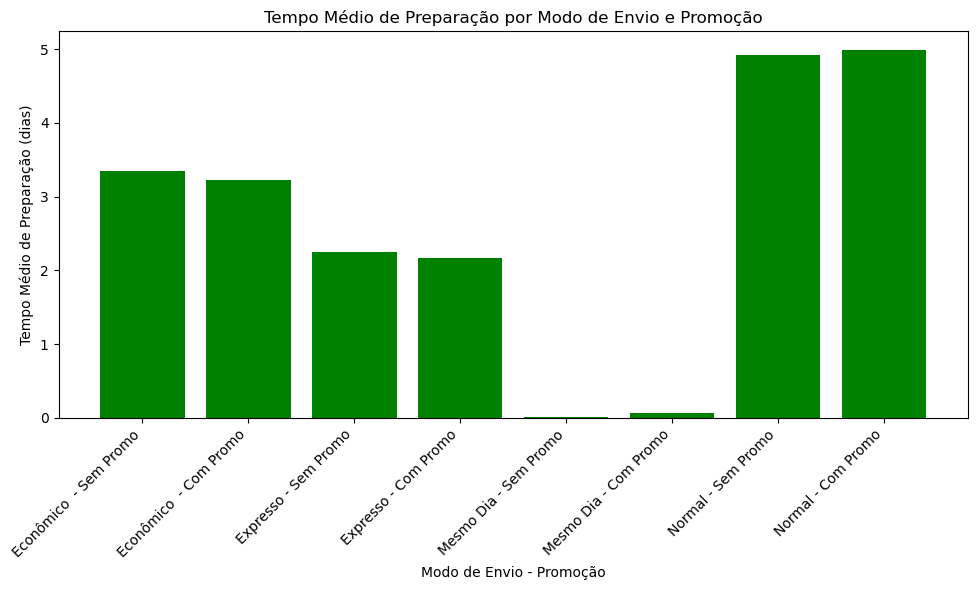

In [23]:


stats['label'] = stats['modo_envio'] + ' - ' + stats['dia_promocional'].map({False:'Sem Promo', True:'Com Promo'})

plt.figure(figsize=(10, 6))
plt.bar(stats['label'], stats['mean_tempo_preparacao'], color='green')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Modo de Envio - Promoção')
plt.ylabel('Tempo Médio de Preparação (dias)')
plt.title('Tempo Médio de Preparação por Modo de Envio e Promoção')
plt.tight_layout()
plt.show()